### Подготовим датасет:
1) Скачаем UniversalDependencies (https://github.com/UniversalDependencies/UD_Russian-SynTagRus?tab=readme-ov-file)

In [37]:
train_path = "syntagrus/ru_syntagrus-ud-train-a.conllu"
dev_path = "syntagrus/ru_syntagrus-ud-dev.conllu"
test_path = "syntagrus/ru_syntagrus-ud-test.conllu"

2) Распарсим файлы и извлечем правила лемматизации

In [38]:
import re

def parse_conllu(filepath):
    sentences = []
    current = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                if current:
                    sentences.append(current)
                    current = []
                continue
            if line.startswith('#'):
                continue
            parts = line.split('\t')
            
            if '-' in parts[0] or '.' in parts[0]:
                continue
            word  = parts[1]   
            lemma = parts[2]   
            upos  = parts[3]   
            current.append((word, lemma, upos))
    if current:
        sentences.append(current)
    return sentences

def get_lemma_rule(word, lemma):
    word_lower = word.lower()
    lemma_lower = lemma.lower()

    common = 0
    for w_ch, l_ch in zip(word_lower, lemma_lower):
        if w_ch == l_ch:
            common += 1
        else:
            break

    strip_len = len(word_lower) - common
    append = lemma_lower[common:]

    return f"-{strip_len}+{append}"

def apply_lemma_rule(word, rule):
    match = re.match(r'-(\d+)\+(.*)', rule)
    strip_len = int(match.group(1))
    append = match.group(2)

    word_lower = word.lower()
    if strip_len > 0:
        stem = word_lower[:-strip_len]
    else:
        stem = word_lower
    return stem + append

3. Загружаем данные: тестовые, валидационные и тренировочные

In [39]:
train_sentences = parse_conllu(train_path)
val_sentences = parse_conllu(dev_path)
test_sentences = parse_conllu(test_path)

print(len(train_sentences))
print(len(val_sentences))
print(len(test_sentences))

print(train_sentences[:2])

24516
8906
8800
[[('Анкета', 'анкета', 'NOUN'), ('.', '.', 'PUNCT')], [('Начальник', 'начальник', 'NOUN'), ('областного', 'областной', 'ADJ'), ('управления', 'управление', 'NOUN'), ('связи', 'связь', 'NOUN'), ('Семен', 'Семен', 'PROPN'), ('Еремеевич', 'Еремеевич', 'PROPN'), ('был', 'быть', 'AUX'), ('человек', 'человек', 'NOUN'), ('простой', 'простой', 'ADJ'), (',', ',', 'PUNCT'), ('приходил', 'приходить', 'VERB'), ('на', 'на', 'ADP'), ('работу', 'работа', 'NOUN'), ('всегда', 'всегда', 'ADV'), ('вовремя', 'вовремя', 'ADV'), (',', ',', 'PUNCT'), ('здоровался', 'здороваться', 'VERB'), ('с', 'с', 'ADP'), ('секретаршей', 'секретарша', 'NOUN'), ('за', 'за', 'ADP'), ('руку', 'рука', 'NOUN'), ('и', 'и', 'CCONJ'), ('иногда', 'иногда', 'ADV'), ('даже', 'даже', 'PART'), ('писал', 'писать', 'VERB'), ('в', 'в', 'ADP'), ('стенгазету', 'стенгазета', 'NOUN'), ('заметки', 'заметка', 'NOUN'), ('под', 'под', 'ADP'), ('псевдонимом', 'псевдоним', 'NOUN'), ('"', '"', 'PUNCT'), ('Муха', 'муха', 'NOUN'), ('"'

3) Собираем все правила и теги, составляем словари

In [40]:
from collections import Counter

word_counter = Counter()
rule_counter = Counter()
tag_counter = Counter()

for sent in train_sentences:
    for word, lemma, upos in sent:
        word_counter[word.lower()] += 1
        rule_counter[get_lemma_rule(word, lemma)] += 1
        tag_counter[upos] += 1

print(f"уникальные слова: {len(word_counter)}")
print(f"уникальные правила: {len(rule_counter)}")
print(f"уникальные теги: {len(tag_counter)}")

# MIN_WORD_FREQ = 5
MIN_WORD_FREQ = 3


word2idx = {"<PAD>": 0, "<UNK>": 1}
for word, count in word_counter.items():
    if count >= MIN_WORD_FREQ:
        word2idx[word] = len(word2idx)

print(f"размер словаря: {len(word2idx)}")
print(f"max индекс: {max(word2idx.values())}")
assert max(word2idx.values()) == len(word2idx) - 1, "дырки в словаре!"
print("ок")

tag2idx = {"<PAD>": 0}
for tag in tag_counter:
    tag2idx[tag] = len(tag2idx)

rule2idx = {"<PAD>": 0, "<UNK>": 1}
for rule in rule_counter:
    rule2idx[rule] = len(rule2idx)

idx2tag  = {v: k for k, v in tag2idx.items()}
idx2rule = {v: k for k, v in rule2idx.items()}

print(f"\nword2idx size: {len(word2idx)}")
print(f"tag2idx  size: {len(tag2idx)}")
print(f"rule2idx size: {len(rule2idx)}")

уникальные слова: 62528
уникальные правила: 891
уникальные теги: 17
размер словаря: 16848
max индекс: 16847
ок

word2idx size: 16848
tag2idx  size: 18
rule2idx size: 893


4) Конвертируем данные в числа

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def encode_sentences(sents, word2idx, tag2idx, rule2idx):
    X_words = []
    Y_tags = []
    Y_rules = []

    for sent in sents:
        w_ids, t_ids, r_ids = [], [], []
        for word, lemma, upos in sent:
            w_ids.append(word2idx.get(word.lower(), word2idx["<UNK>"]))
            t_ids.append(tag2idx.get(upos, 0))
            rule = get_lemma_rule(word, lemma)
            r_ids.append(rule2idx.get(rule, rule2idx["<UNK>"]))
        X_words.append(w_ids)
        Y_tags.append(t_ids)
        Y_rules.append(r_ids)

    X_words = pad_sequences(X_words, padding='post', value=0)
    Y_tags  = pad_sequences(Y_tags,  padding='post', value=0)
    Y_rules = pad_sequences(Y_rules, padding='post', value=0)

    return X_words, Y_tags, Y_rules

X_train, y_train_tags, y_train_rules = encode_sentences(train_sentences, word2idx, tag2idx, rule2idx)
X_val,   y_val_tags,   y_val_rules   = encode_sentences(val_sentences,   word2idx, tag2idx, rule2idx)
X_test,  y_test_tags,  y_test_rules  = encode_sentences(test_sentences,  word2idx, tag2idx, rule2idx)

print(f"X_train:       {X_train.shape}")
print(f"y_train_tags:  {y_train_tags.shape}")
print(f"y_train_rules: {y_train_rules.shape}")

X_train:       (24516, 193)
y_train_tags:  (24516, 193)
y_train_rules: (24516, 193)


Данные для обучения готовы. 
### Создадим модель на основе библиотеки keras.

In [42]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np

EMBED_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 64
EPOCHS = 30
DROPOUP = 0.3
REC_DROPOUT = 0.2

input_words = layers.Input(shape=(None,), name='words')

# общий энкодер
x = layers.Embedding(len(word2idx) + 1, EMBED_DIM, mask_zero=True)(input_words)
x = layers.Bidirectional(layers.LSTM(HIDDEN_DIM, return_sequences=True, dropout=DROPOUP, recurrent_dropout=REC_DROPOUT))(x)
x = layers.Dropout(DROPOUP)(x)
x = layers.Bidirectional(layers.LSTM(HIDDEN_DIM // 2, return_sequences=True, dropout=DROPOUP, recurrent_dropout=REC_DROPOUT))(x)
x = layers.Dropout(DROPOUP)(x)

# pos tag
pos_out = layers.Dense(len(tag2idx), activation='softmax', name='pos')(x)

# правила лемматизации
lemma_out = layers.Dense(len(rule2idx), activation='softmax', name='lemma')(x)

model = keras.Model(inputs=input_words, outputs=[pos_out, lemma_out])

# accuracy, игнорирующий pad
def masked_accuracy(y_true, y_pred):
    pred = tf.cast(tf.argmax(y_pred, axis=-1), y_true.dtype)
    mask = tf.not_equal(y_true, 0)                         
    correct = tf.logical_and(tf.equal(pred, y_true), mask) 
    return tf.reduce_sum(tf.cast(correct, tf.float32)) / (tf.reduce_sum(tf.cast(mask, tf.float32)) + 1e-8)


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'pos':   keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none'),
        'lemma': keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none'),
    },
    loss_weights={
        'pos':   1.0,
        'lemma': 1.0,
    },
    metrics={
        'pos':   [masked_accuracy],
        'lemma': [masked_accuracy],
    }
)

model.summary()

train_mask = (X_train != 0).astype("float32")
val_mask   = (X_val   != 0).astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices((
    X_train,
    (y_train_tags, y_train_rules),
    (train_mask,  train_mask),
)).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((
    X_val,
    (y_val_tags, y_val_rules),
    (val_mask,  val_mask),
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',         
        mode='min',
        patience=3,
        restore_best_weights=True 
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.5,
        patience=1,                  
        min_lr=1e-5
    ),
]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, None)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 128)            2156672   ['words[0][0]']               
                                                                                                  
 bidirectional_2 (Bidirecti  (None, None, 512)            788480    ['embedding_1[0][0]']         
 onal)                                                                                            
                                                                                                  
 dropout_2 (Dropout)         (None, None, 512)            0         ['bidirectional_2[0][0]'

Обучение

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
384/384 [==============================] - 963s 2s/step - loss: 0.3214 - pos_loss: 0.1349 - lemma_loss: 0.1865 - pos_masked_accuracy: 0.5097 - lemma_masked_accuracy: 0.5947 - val_loss: 0.2724 - val_pos_loss: 0.0753 - val_lemma_loss: 0.1971 - val_pos_masked_accuracy: 0.8046 - val_lemma_masked_accuracy: 0.6304 - lr: 0.0010
Epoch 2/30
384/384 [==============================] - 913s 2s/step - loss: 0.1549 - pos_loss: 0.0384 - lemma_loss: 0.1165 - pos_masked_accuracy: 0.8622 - lemma_masked_accuracy: 0.6875 - val_loss: 0.1998 - val_pos_loss: 0.0489 - val_lemma_loss: 0.1509 - val_pos_masked_accuracy: 0.8702 - val_lemma_masked_accuracy: 0.7087 - lr: 0.0010
Epoch 3/30
384/384 [==============================] - 907s 2s/step - loss: 0.1151 - pos_loss: 0.0280 - lemma_loss: 0.0870 - pos_masked_accuracy: 0.8982 - lemma_masked_accuracy: 0.7731 - val_loss: 0.1719 - val_pos_loss: 0.0451 - val_lemma_loss: 0.1267 - val_pos_masked_accuracy: 0.8771 - val_lemma_masked_accuracy: 0.7677 - lr: 0.001

Получаем следующую **accuracy** для **lemmatizer_model1.keras**: 

Epoch 30/30
loss: 0.0022 - pos_loss: 2.4227e-04 - lemma_loss: 0.0015 - **pos_masked_accuracy: 0.9993** - **lemma_masked_accuracy: 0.9960** - val_loss: 0.4282 - val_pos_loss: 0.0924 - val_lemma_loss: 0.1510 - **val_pos_masked_accuracy: 0.8954** - **val_lemma_masked_accuracy: 0.8583** - lr: 5.0000e-04

Получаем следующую **accuracy** для **lemmatizer_model3.keras**: 

Epoch 19/30
loss: 0.0457 - pos_loss: 0.0119 - lemma_loss: 0.0338 - **pos_masked_accuracy: 0.9557** - **lemma_masked_accuracy: 0.9060** - val_loss: 0.1256 - val_pos_loss: 0.0398 - val_lemma_loss: 0.0859 - **val_pos_masked_accuracy: 0.8989** - **val_lemma_masked_accuracy: 0.8427** - lr: 2.5000e-04


Установим название файлов для сохранения

In [25]:
import json

NAME_MODEL = 'lemmatizer_model3.keras'
NAME_VOCAB = 'vocabs3.json'

Сохраним обученную модель

In [ ]:

model.save(NAME_MODEL)

vocabs = {
    'word2idx': word2idx,
    'tag2idx':  tag2idx,
    'rule2idx': rule2idx,
    'idx2tag':  idx2tag,
    'idx2rule': idx2rule,
}

vocabs_serializable = {
    'word2idx': word2idx,
    'tag2idx':  tag2idx,
    'rule2idx': rule2idx,
    'idx2tag':  {str(k): v for k, v in idx2tag.items()},
    'idx2rule': {str(k): v for k, v in idx2rule.items()},
}

with open(NAME_VOCAB, 'w', encoding='utf-8') as f:
    json.dump(vocabs_serializable, f, ensure_ascii=False)


print("модель сохранена: " + NAME_MODEL)
print("словари сохранены: " + NAME_VOCAB)

модель сохранена: lemmatizer_model3.keras
словари сохранены: vocabs3.json


Загрузим модель из файла

In [27]:
with open(NAME_VOCAB, 'r', encoding='utf-8') as f:
    vocabs = json.load(f)

word2idx = vocabs['word2idx']
tag2idx  = vocabs['tag2idx']
rule2idx = vocabs['rule2idx']
idx2tag  = {int(k): v for k, v in vocabs['idx2tag'].items()}
idx2rule = {int(k): v for k, v in vocabs['idx2rule'].items()}

def masked_accuracy(y_true, y_pred):
    pred = tf.cast(tf.argmax(y_pred, axis=-1), y_true.dtype)
    mask = tf.not_equal(y_true, 0)
    correct = tf.logical_and(tf.equal(pred, y_true), mask)
    return tf.reduce_sum(tf.cast(correct, tf.float32)) / (tf.reduce_sum(tf.cast(mask, tf.float32)) + 1e-8)

model = keras.models.load_model(
    NAME_MODEL,
    custom_objects={'masked_accuracy': masked_accuracy}
)


print("модель загружена")
print(f"словарь: {len(word2idx)} слов, {len(idx2tag)} тегов, {len(idx2rule)} правил")


модель загружена
словарь: 16848 слов, 18 тегов, 893 правил


### Протестируем модель на разных предложениях

In [35]:
punct_pattern = re.compile(r"[^\w\s-]", re.UNICODE)

def lemmatize(text):
    if isinstance(text, str):
        text = punct_pattern.sub("", text)
        words = text.split()
    else:
        words = [punct_pattern.sub("", w) for w in text]
        words = [w for w in words if w]

    if len(words) == 0:
        return ""
    
    ids = [word2idx.get(w.lower(), word2idx["<UNK>"]) for w in words]
    ids_padded = np.array([ids])

    pos_probs, lemma_probs = model.predict(ids_padded, verbose=0)
    pos_ids  = np.argmax(pos_probs[0],  axis=-1)
    rule_ids = np.argmax(lemma_probs[0], axis=-1)

    parts = []
    for i, word in enumerate(words):
        tag   = idx2tag.get(pos_ids[i], "???")
        rule  = idx2rule.get(rule_ids[i], "-0+")
        lemma = apply_lemma_rule(word, rule)
        parts.append(f"{word}{{{lemma}={tag}}}")

    return " ".join(parts)


test_sentences = [
    "Красивые кошки бежали по зелёной траве",
    "Я люблю программирование на Питоне",
    "Студенты сдали сложные экзамены досрочно",
    "В московских парках расцвели первые цветы",
    "Я поймал кринж от пары",
    "Сегодня я и мои друзья не пойдут в ВУЗ, счастливый день", 
    "Скоро наступит любимая весна, будет ярко светить солнышко на улице, и мы все выйдем гулять!", 
]

for sent in test_sentences:
    print(lemmatize(sent))
    print()

Красивые{красивый=ADJ} кошки{кошкй=ADJ} бежали{бежать=VERB} по{по=ADP} зелёной{зелён=NOUN} траве{тра=NOUN}

Я{я=PRON} люблю{любить=VERB} программирование{программирование=VERB} на{на=ADP} Питоне{питоне=NOUN}

Студенты{студенты=PUNCT} сдали{сдалй=PUNCT} сложные{сложный=ADJ} экзамены{экзамен=NOUN} досрочно{досрочно=PUNCT}

В{в=PUNCT} московских{московский=NOUN} парках{паркь=NOUN} расцвели{расцвеле=NOUN} первые{первый=ADJ} цветы{цветы=NOUN}

Я{я=PRON} поймал{поймать=VERB} кринж{кринж=NOUN} от{от=ADP} пары{пара=NOUN}

Сегодня{сегодня=ADV} я{я=PRON} и{и=PART} мои{мой=DET} друзья{друг=NOUN} не{не=PART} пойдут{пойти=VERB} в{в=ADP} ВУЗ{вуз=NOUN} счастливый{счастливый=ADJ} день{день=NOUN}

Скоро{скоро=ADV} наступит{наступить=VERB} любимая{любимый=ADJ} весна{весна=NOUN} будет{быть=AUX} ярко{ярко=ADV} светить{светить=VERB} солнышко{солнышко=NOUN} на{на=ADP} улице{улица=NOUN} и{и=CCONJ} мы{мы=PRON} все{весь=PART} выйдем{выйдеодобный=PUNCT} гулять{гулять=PUNCT}



### Чем отличаются все модели?

1) lemmatizer_model1.keras - первая модель, словарь содержит 62530 слов, 18 тегов, 893 правил
2) lemmatizer_model2.keras - вторая модель, словарь содержит 9666 слов, 18 тегов, 893 правил
3) lemmatizer_model3.keras - третья модель, словарь содержит 16848 слов, 18 тегов, 893 правил

Первая модель

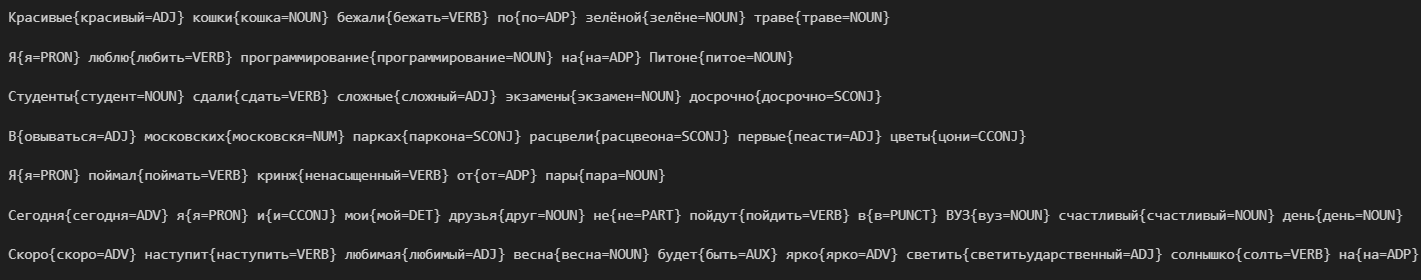
![alt text](image-1.png)

Вторая модель

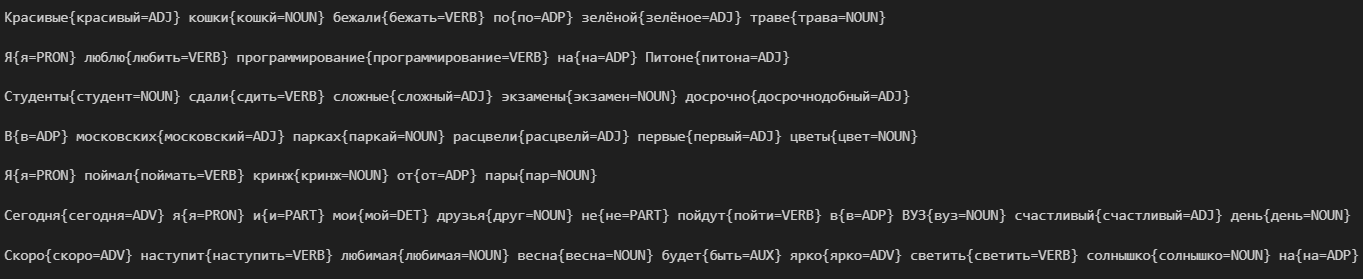
![alt text](image-2.png)

Третья модель:

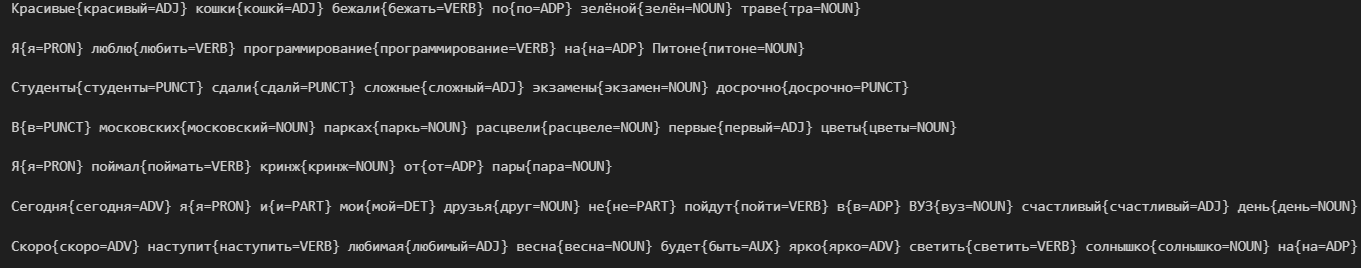
![alt text](image-3.png)